In [4]:
import json
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import spectral

In [5]:
def extract_filename_with_ripeness(json_file_path , filenames_with_ripeness):

    # Open the file and load the JSON data
    with open(json_file_path, 'r') as f:
        data = json.load(f)


    # Iterate over the data to extract the relevant info
    for i in range(len(data['records'])):
        if data['records'][i]['fruit'] == 'Mango':  # Add the constraint for 'Avocados'
            filenames_with_ripeness[data['records'][i]['files']['data_file']] = data['annotations'][i]['ripeness_state']

        

In [6]:
# Initialize lists for filenames and ripeness states
filenames_with_ripeness = {}

# Load JSON file from the parent folder
json_file_path = os.path.join('train_only_labeled.json')
extract_filename_with_ripeness(json_file_path , filenames_with_ripeness)
len(filenames_with_ripeness)

112

In [7]:
# Load JSON file from the parent folder
json_file_path = os.path.join('test.json')
extract_filename_with_ripeness(json_file_path , filenames_with_ripeness)
len(filenames_with_ripeness)

136

In [8]:
# Load JSON file from the parent folder
json_file_path = os.path.join('val.json')
extract_filename_with_ripeness(json_file_path , filenames_with_ripeness)
len(filenames_with_ripeness)

160

In [9]:
filenames_with_ripeness

{'Mango/VIS/day_11_m3/mango_day_11_m3_01_back.bin': 'perfect',
 'Mango/VIS_COR/day_11_m3/mango_day_11_m3_01_front.bin': 'perfect',
 'Mango/VIS_COR/day_11_m3/mango_day_11_m3_01_back.bin': 'perfect',
 'Mango/VIS/day_10_m3/mango_day_10_m3_02_front.bin': 'perfect',
 'Mango/VIS/day_10_m3/mango_day_10_m3_02_back.bin': 'perfect',
 'Mango/VIS_COR/day_10_m3/mango_day_10_m3_02_back.bin': 'perfect',
 'Mango/VIS/day_2_m3/mango_day_2_m3_03_back.bin': 'unripe',
 'Mango/VIS_COR/day_2_m3/mango_day_2_m3_03_front.bin': 'unripe',
 'Mango/VIS_COR/day_2_m3/mango_day_2_m3_03_back.bin': 'unripe',
 'Mango/VIS/day_9_m3/mango_day_9_m3_04_back.bin': 'unripe',
 'Mango/VIS/day_5_m3/mango_day_5_m3_05_front.bin': 'unripe',
 'Mango/VIS/day_5_m3/mango_day_5_m3_05_back.bin': 'unripe',
 'Mango/VIS_COR/day_5_m3/mango_day_5_m3_05_front.bin': 'unripe',
 'Mango/VIS_COR/day_5_m3/mango_day_5_m3_05_back.bin': 'unripe',
 'Mango/VIS/day_8_m3/mango_day_8_m3_06_front.bin': 'perfect',
 'Mango/VIS_COR/day_8_m3/mango_day_8_m3_06_fron

In [10]:
os.environ["SPECTRAL_DATA"] = ""

In [11]:
# Define ripeness label mapping to numeric values
ripeness_labels = {"unripe": 0, "perfect": 1, "overripe": 2}

class MangoRipenessDataset(Dataset):
    def __init__(self, data_dict, ripeness_labels, dataset_root):
        """
        :param data_dict: Dictionary with file paths as keys and ripeness labels as values
        :param ripeness_labels: Dictionary mapping ripeness states to numeric labels
        :param dataset_root: Root directory of the dataset containing the bin and hdr files
        """
        self.data_dict = data_dict
        self.ripeness_labels = ripeness_labels
        self.dataset_root = dataset_root  # Root folder where the bin files are stored
        self.files = list(data_dict.keys())  # List of file paths

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Get the file path and ripeness label
        file_path = self.files[idx]
        full_path = os.path.join(self.dataset_root, file_path)
        hdr_path = full_path.replace('.bin', '.hdr')

        # Open the hyperspectral image explicitly specifying both .hdr and .bin files
        try:
            hyperspectral_image = spectral.envi.open(hdr_path, full_path).load()
        except Exception as e:
            print(f"Error loading {full_path}: {e}")
            raise

        # Convert hyperspectral data to tensor
        data = torch.tensor(hyperspectral_image).float()

        # Get the label and convert to tensor
        label_str = self.data_dict[file_path]
        label = torch.tensor(self.ripeness_labels[label_str]).long()
        print(label)
        
        return data, label





In [12]:
# Initialize the dataset and data loader
dataset_root = ""  # Replace with the actual path to the dataset folder
dataset = MangoRipenessDataset(filenames_with_ripeness, ripeness_labels, dataset_root)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [13]:
sample_img , _ = dataset[46]
sample_img_np = sample_img.numpy()

tensor(1)


/home/bail/deeplearning/deeplearning_env/pytorch_env/lib/python3.11/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.0053137242794036865, 0.15763649344444275]
    G: [-0.0023659109137952328, 0.10605469346046448]
    B: [-0.008793169632554054, 0.7110670804977417]

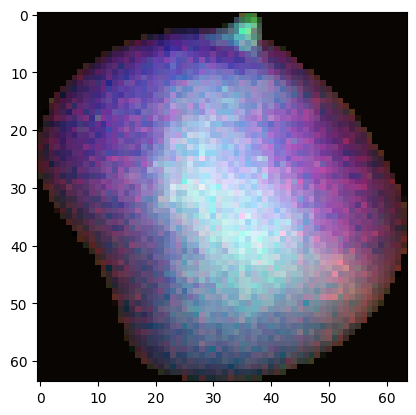

In [14]:
spectral.imshow(sample_img_np[:,:,[2,54,160]])

In [15]:
sample_img_np.shape

(64, 64, 249)

In [16]:
type(dataset[0])

tensor(1)


tuple

In [17]:
import torch
import torch.nn.functional as F

def save_dataset_with_padding(dataset, filename, target_shape=(64, 64, 249)):
    data_list = []
    label_list = []
    
    # Iterate over the dataset to gather all data and labels
    for idx in range(len(dataset)):
        data, label = dataset[idx]

        # Pad the tensor to the target shape (64, 64, 249)
        padding_dims = (0, target_shape[2] - data.shape[2])  # Pad along the last dimension only
        data_padded = F.pad(data, padding_dims, "constant", 0)  # Pad with zeros
        
        data_list.append(data_padded)
        label_list.append(label)
    
    # Convert lists of data and labels into tensors
    data_tensor = torch.stack(data_list)
    label_tensor = torch.stack(label_list)
    
    # Save to a single file
    torch.save({'data': data_tensor, 'labels': label_tensor}, filename)

# Example usage
save_dataset_with_padding(data_loader.dataset, 'mango_ripeness_tensordataset.pt')


tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(2)
tensor(2)
tensor(2)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(2)
tensor(2)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(0)
tensor(0)
tensor(2)
tensor(2)


In [18]:
loaded_data = torch.load('mango_ripeness_tensordataset.pt')
newdata = loaded_data['data']
newlabels = loaded_data['labels']

In [19]:
len(loaded_data['data'])

160